In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import ensemble, preprocessing, metrics
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils import np_utils
np.random.seed(10)
import csv

In [2]:
SDNdata = pd.read_csv("C:\pythonwork\dataset_sdn.csv")
print(SDNdata.describe())

                  dt         switch       pktcount     bytecount  \
count  104345.000000  104345.000000  104345.000000  1.043450e+05   
mean    17927.514169       4.214260   52860.954746  3.818660e+07   
std     11977.642655       1.956327   52023.241460  4.877748e+07   
min      2488.000000       1.000000       0.000000  0.000000e+00   
25%      7098.000000       3.000000     808.000000  7.957600e+04   
50%     11905.000000       4.000000   42828.000000  6.471930e+06   
75%     29952.000000       5.000000   94796.000000  7.620354e+07   
max     42935.000000      10.000000  260006.000000  1.471280e+08   

                 dur      dur_nsec       tot_dur          flows  \
count  104345.000000  1.043450e+05  1.043450e+05  104345.000000   
mean      321.497398  4.613880e+08  3.218865e+11       5.654234   
std       283.518232  2.770019e+08  2.834029e+11       2.950036   
min         0.000000  0.000000e+00  0.000000e+00       2.000000   
25%       127.000000  2.340000e+08  1.270000e+11    

# 資料前處理

In [3]:
#先把NULL值的資料Drop掉
SDNdata.dropna(inplace=True)
SDNdata.shape

(103839, 23)

In [4]:
fe=SDNdata.groupby('Protocol').size()/len(SDNdata)
SDNdata.loc[:,'Protocol']=SDNdata['Protocol'].map(fe)

In [5]:
fe=SDNdata.groupby('dst').size()/len(SDNdata)
SDNdata.loc[:,'dst']=SDNdata['dst'].map(fe)

In [6]:
fe=SDNdata.groupby('src').size()/len(SDNdata)
SDNdata.loc[:,'src']=SDNdata['src'].map(fe)

In [7]:
#把資料分為屬性和標籤，然後20%測試80%訓練
x = SDNdata.drop('label', axis=1)
y = SDNdata['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20,random_state=100)

In [8]:
#指定陣列
df_x_train =pd.DataFrame(x_train)
df_x_test =pd.DataFrame(x_test)
df_y_train =pd.DataFrame(y_train)
df_y_test =pd.DataFrame(y_test)

In [9]:
#標準化
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_x_train=minmax_scale.fit_transform(df_x_train)
scaled_x_test=minmax_scale.fit_transform(df_x_test)
scaled_y_train=minmax_scale.fit_transform(df_y_train)
scaled_y_test=minmax_scale.fit_transform(df_y_test)

In [10]:
scaled_x_train.shape

(83071, 22)

In [11]:
scaled_y_train.shape

(83071, 1)

In [12]:
scaled_x_test.shape

(20768, 22)

In [13]:
scaled_y_test.shape

(20768, 1)

In [14]:
X_train = np.reshape(scaled_x_train, (scaled_x_train.shape[0], 1, scaled_x_train.shape[1]))

X_test = np.reshape(scaled_x_test, (scaled_x_test.shape[0], 1, scaled_x_test.shape[1]))

In [15]:
X_train.shape

(83071, 1, 22)

In [16]:
X_test.shape

(20768, 1, 22)

# 建立模型

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, LSTM, Bidirectional,GRU


In [18]:
model = Sequential()

In [19]:
model.add(GRU(120,input_shape=(1, 22), return_sequences=True))

In [20]:
model.add(Dropout(0.2))

In [21]:
model.add(GRU(120, return_sequences=True))

In [22]:
model.add(Dropout(0.2))

In [23]:
model.add(GRU(120, return_sequences=False))

In [24]:
model.add(Dropout(0.2))

In [25]:
model.add(Dense(1, activation="sigmoid"))

In [26]:
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 120)            51840     
_________________________________________________________________
dropout (Dropout)            (None, 1, 120)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 120)            87120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 120)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 120)               87120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [29]:
# 開始訓練  
start = process_time()
train_history = model.fit(X_train, scaled_y_train, epochs=200, validation_split=0.1, batch_size=1000)
stop = process_time()

Epoch 1/200
75/75 [==============================] - 4s 54ms/step - loss: 0.1067 - accuracy: 0.9528 - val_loss: 0.0933 - val_accuracy: 0.9587
Epoch 2/200
75/75 [==============================] - 4s 52ms/step - loss: 0.1049 - accuracy: 0.9536 - val_loss: 0.0920 - val_accuracy: 0.9590
Epoch 3/200
75/75 [==============================] - 4s 53ms/step - loss: 0.1017 - accuracy: 0.9554 - val_loss: 0.0890 - val_accuracy: 0.9626
Epoch 4/200
75/75 [==============================] - 4s 54ms/step - loss: 0.1013 - accuracy: 0.9556 - val_loss: 0.0889 - val_accuracy: 0.9609
Epoch 5/200
75/75 [==============================] - 4s 52ms/step - loss: 0.0996 - accuracy: 0.9562 - val_loss: 0.0876 - val_accuracy: 0.9621
Epoch 6/200
75/75 [==============================] - 4s 54ms/step - loss: 0.0960 - accuracy: 0.9576 - val_loss: 0.0838 - val_accuracy: 0.9641
Epoch 7/200
75/75 [==============================] - 4s 53ms/step - loss: 0.0937 - accuracy: 0.9590 - val_loss: 0.0816 - val_accuracy: 0.9636
Epoch 

Epoch 58/200
75/75 [==============================] - 4s 50ms/step - loss: 0.0543 - accuracy: 0.9762 - val_loss: 0.0452 - val_accuracy: 0.9813
Epoch 59/200
75/75 [==============================] - 4s 52ms/step - loss: 0.0528 - accuracy: 0.9768 - val_loss: 0.0459 - val_accuracy: 0.9801
Epoch 60/200
75/75 [==============================] - 4s 52ms/step - loss: 0.0532 - accuracy: 0.9771 - val_loss: 0.0434 - val_accuracy: 0.9817
Epoch 61/200
75/75 [==============================] - 4s 49ms/step - loss: 0.0514 - accuracy: 0.9776 - val_loss: 0.0459 - val_accuracy: 0.9805
Epoch 62/200
75/75 [==============================] - 4s 51ms/step - loss: 0.0520 - accuracy: 0.9774 - val_loss: 0.0423 - val_accuracy: 0.9815
Epoch 63/200
75/75 [==============================] - 4s 52ms/step - loss: 0.0513 - accuracy: 0.9780 - val_loss: 0.0406 - val_accuracy: 0.9831
Epoch 64/200
75/75 [==============================] - 4s 55ms/step - loss: 0.0504 - accuracy: 0.9778 - val_loss: 0.0414 - val_accuracy: 0.9824

75/75 [==============================] - 5s 64ms/step - loss: 0.0375 - accuracy: 0.9835 - val_loss: 0.0270 - val_accuracy: 0.9876
Epoch 115/200
75/75 [==============================] - 5s 67ms/step - loss: 0.0343 - accuracy: 0.9854 - val_loss: 0.0265 - val_accuracy: 0.9890
Epoch 116/200
75/75 [==============================] - 5s 68ms/step - loss: 0.0340 - accuracy: 0.9853 - val_loss: 0.0270 - val_accuracy: 0.9875
Epoch 117/200
75/75 [==============================] - 5s 67ms/step - loss: 0.0367 - accuracy: 0.9844 - val_loss: 0.0310 - val_accuracy: 0.9869
Epoch 118/200
75/75 [==============================] - 5s 67ms/step - loss: 0.0345 - accuracy: 0.9851 - val_loss: 0.0264 - val_accuracy: 0.9878
Epoch 119/200
75/75 [==============================] - 5s 69ms/step - loss: 0.0350 - accuracy: 0.9849 - val_loss: 0.0267 - val_accuracy: 0.9889
Epoch 120/200
75/75 [==============================] - 5s 64ms/step - loss: 0.0341 - accuracy: 0.9848 - val_loss: 0.0259 - val_accuracy: 0.9889
Epoch 

Epoch 171/200
75/75 [==============================] - 3s 46ms/step - loss: 0.0311 - accuracy: 0.9861 - val_loss: 0.0210 - val_accuracy: 0.9912
Epoch 172/200
75/75 [==============================] - 4s 49ms/step - loss: 0.0268 - accuracy: 0.9880 - val_loss: 0.0207 - val_accuracy: 0.9904
Epoch 173/200
75/75 [==============================] - 4s 48ms/step - loss: 0.0262 - accuracy: 0.9888 - val_loss: 0.0197 - val_accuracy: 0.9922
Epoch 174/200
75/75 [==============================] - 3s 46ms/step - loss: 0.0269 - accuracy: 0.9884 - val_loss: 0.0205 - val_accuracy: 0.9899
Epoch 175/200
75/75 [==============================] - 3s 47ms/step - loss: 0.0293 - accuracy: 0.9875 - val_loss: 0.0209 - val_accuracy: 0.9910
Epoch 176/200
75/75 [==============================] - 4s 49ms/step - loss: 0.0277 - accuracy: 0.9887 - val_loss: 0.0207 - val_accuracy: 0.9921
Epoch 177/200
75/75 [==============================] - 3s 44ms/step - loss: 0.0266 - accuracy: 0.9887 - val_loss: 0.0212 - val_accuracy:

In [30]:
print("Time(s):",stop-start)

Time(s): 2281.921875


# 效能評估

In [31]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

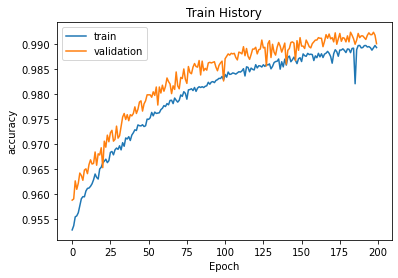

In [32]:
show_train_history(train_history,'accuracy','val_accuracy')

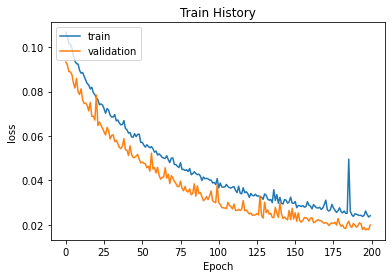

In [33]:
show_train_history(train_history,'loss','val_loss')

In [34]:
scores = model.evaluate(X_test, y_test)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

649/649 [==============================] - 2s 2ms/step - loss: 0.0189 - accuracy: 0.9917

	[Info] Accuracy of testing data = 99.2%
